## Password_Strength_Classifier V2
using zxcvbn to label data


### import package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random,string
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Exploratory Analysis & Preprocessing

Sample data size:(5993, 2)
           password  strength
0            d04m11         0
1          abizar08         1
2       whosdabest1         1
3          8g8x2su3         1
4  Zdyf0kjMzNQycqPx         2


b'Skipping line 41864: expected 2 fields, saw 5\nSkipping line 377759: expected 2 fields, saw 5\nSkipping line 526251: expected 2 fields, saw 5\nSkipping line 534146: expected 2 fields, saw 5\nSkipping line 553002: expected 2 fields, saw 5\nSkipping line 585885: expected 2 fields, saw 5\n'


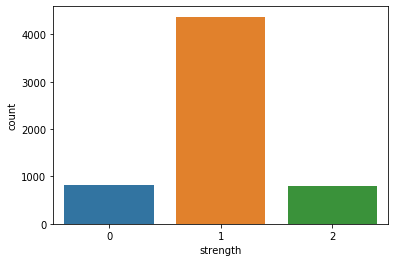

In [2]:
filename = './data_kaggle.csv'
# Count the lines
num_lines = sum(1 for l in open(filename))
# Sample size - in this case ~10%
size = 6000 #int(num_lines / 10)
# The row indices to skip - make sure 0 is not included to keep the header!
random.seed(33)
skip_idx = random.sample(range(1, num_lines), num_lines - size)
data = pd.read_csv(filename,skiprows=skip_idx, error_bad_lines = False)
data.dropna(inplace=True) # drop NaN row
print(f"Sample data size:{data.shape}\n{data.head()}")
sns.countplot(data['strength']) # Distribution graphs
plt.show()

### Using zxcvbn to analyse data

Sample data:(5993, 3)
           password  strength  newLabel
0            d04m11         0         1
1          abizar08         1         2
2       whosdabest1         1         4
3          8g8x2su3         1         2
4  Zdyf0kjMzNQycqPx         2         4
value distribution: 3    1920
2    1707
4    1235
1    1127
0       4
Name: newLabel, dtype: int64


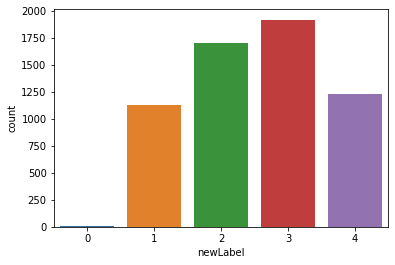

In [3]:
from zxcvbn import zxcvbn
data['newLabel'] = data['password'].apply(lambda x: zxcvbn(x)['score'])
print(f"Sample data:{data.shape}\n{data.head()}")
print("value distribution:",data['newLabel'].value_counts())
sns.countplot(data['newLabel']) # Distribution graphs

In [4]:
# sns.countplot(data[data.strength==1]['newLabel'])
# sns.countplot(data[data.newLabel==1]['strength'])


## feature extraction

### hand-designed feature

In [5]:
df1 = data.copy()
df1['length'] = df1['password'].str.len()
df1['numerics'] = df1['password'].apply(lambda x: len([str(x) for x in list(x) if str(x).isdigit()]))
df1['alpha'] = df1['password'].apply(lambda x: len([x for x in list(x) if x.isalpha()]))
df1['lowercase'] = df1['password'].apply(lambda x: len([x for x in list(x) if x.islower()]))
df1['uppercase'] = df1['password'].apply(lambda x: len([x for x in list(x) if x.isupper()]))

vowels = ['a', 'e', 'i', 'o', 'u']
df1['vowels'] = df1['password'].apply(lambda x: 
                                      len([x for x in list(x) if x in vowels]))
df1['consonants'] = df1['password'].apply(lambda x: 
                                          len([x for x in list(x) if x not in vowels and x.isalpha()]))
df1['punctuation'] = df1['password'].apply(lambda x: len([x for x in list(x) if x in string.punctuation]))
df1['num_perct'] = df1.apply(lambda x: x['numerics']/x['length'],axis=1)
df1['alpha_perct'] = df1.apply(lambda x: x['alpha']/x['length'],axis=1)
df1['lowercase_ratio'] = df1.apply(lambda x: x['lowercase']/x['length'],axis=1)
df1['uppercase_ratio'] = df1.apply(lambda x: x['uppercase']/x['length'],axis=1)

df1.head()

,password,strength,newLabel,length,numerics,alpha,lowercase,uppercase,vowels,consonants,punctuation,num_perct,alpha_perct,lowercase_ratio,uppercase_ratio
0,d04m11,0,1,6,4,2,2,0,0,2,0,0.666667,0.333333,0.333333,0.0000
1,abizar08,1,2,8,2,6,6,0,3,3,0,0.250000,0.750000,0.750000,0.0000
2,whosdabest1,1,4,11,1,10,10,0,3,7,0,0.090909,0.909091,0.909091,0.0000
3,8g8x2su3,1,2,8,4,4,4,0,1,3,0,0.500000,0.500000,0.500000,0.0000
4,Zdyf0kjMzNQycqPx,2,4,16,1,15,10,5,0,15,0,0.062500,0.937500,0.625000,0.3125


In [6]:
df1 = df1[df1.newLabel != 0]
# df1 = df1[df1.newLabel != 1]
y = df1['newLabel']
X = df1.drop(['strength','newLabel'], axis = 1)
print(X.shape)
X.head()

(5989, 13)


,password,length,numerics,alpha,lowercase,uppercase,vowels,consonants,punctuation,num_perct,alpha_perct,lowercase_ratio,uppercase_ratio
0,d04m11,6,4,2,2,0,0,2,0,0.666667,0.333333,0.333333,0.0000
1,abizar08,8,2,6,6,0,3,3,0,0.250000,0.750000,0.750000,0.0000
2,whosdabest1,11,1,10,10,0,3,7,0,0.090909,0.909091,0.909091,0.0000
3,8g8x2su3,8,4,4,4,0,1,3,0,0.500000,0.500000,0.500000,0.0000
4,Zdyf0kjMzNQycqPx,16,1,15,10,5,0,15,0,0.062500,0.937500,0.625000,0.3125


## Training

In [7]:
from sklearn import tree

X_trval, X_test, y_trval, y_test = train_test_split(X, y, test_size = 0.2, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_trval, y_trval, test_size = 0.2, random_state=33)
print(f"X_trval:{X_trval.shape}, X_test: {X_test.shape}, X_train: {X_train.shape}, X_val: {X_val.shape}")

X_train = X_train.drop('password', axis = 1)
X_val = X_val.drop('password', axis = 1)
X_test = X_test.drop('password', axis = 1)


# Standardize feature 
scaler = StandardScaler().fit(X_train)
X_train_tr = scaler.transform(X_train)
X_test_tr = scaler.transform(X_test)
X_val_tr = scaler.transform(X_val)

X_trval:(4791, 13), X_test: (1198, 13), X_train: (3832, 13), X_val: (959, 13)


### Model selection

In [10]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression(max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier(max_iter=600)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=42,shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Logistic Regression: 0.655017 (0.023836)
LDA: 0.640136 (0.032666)
KNN: 0.670138 (0.020324)
Decision Tree: 0.709807 (0.018131)
Random Forest: 0.716855 (0.019350)
ADA: 0.464007 (0.047798)
Gaussian Naive Bayes: 0.632829 (0.027585)
SVM: 0.717904 (0.010013)
MLP: 0.712162 (0.012072)


### Params of SVM

In [11]:
# prepare models
models = []
models.append(('SVM_linear', SVC(kernel = 'linear')))
models.append(('SVM_poly', SVC(kernel = 'poly',degree = 5)))
models.append(('SVM_rbf', SVC(kernel = 'rbf')))
models.append(('SVM_sigmoid', SVC(kernel = 'sigmoid')))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=42,shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

SVM_linear: 0.657099 (0.017881)
SVM_poly: 0.602044 (0.027548)
SVM_rbf: 0.717904 (0.010013)
SVM_sigmoid: 0.104907 (0.015011)


In [ ]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto'], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 2) 
  
# fitting the model for grid search 
grid.fit(X_train_tr, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

### training...

In [12]:

clf_svm = SVC(random_state=33, gamma='auto',kernel = 'rbf',C=1)


# training
clf_svm.fit(X_train_tr, y_train)


# predict
y_train_pred = clf_svm.predict(X_train_tr)
y_val_pred = clf_svm.predict(X_val_tr)

print("Accuracy of SVM Classifier (Training): {0:.3f}".format(accuracy_score(y_train, y_train_pred)))
print("Accuracy of SVM Classifier (Testing): {0:.3f}".format(accuracy_score(y_val, y_val_pred)))

# save the model to disk
filename = 'clf_svm_v2.model'
pickle.dump(clf_svm, open(filename, 'wb'))

Accuracy of SVM Classifier (Training): 0.732
Accuracy of SVM Classifier (Testing): 0.743


In [14]:
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

              precision    recall  f1-score   support

           1       0.90      0.39      0.55       184
           2       0.76      0.70      0.73       277
           3       0.67      0.89      0.76       302
           4       0.79      0.91      0.85       196

    accuracy                           0.74       959
   macro avg       0.78      0.72      0.72       959
weighted avg       0.77      0.74      0.73       959

[[ 72  50  48  14]
 [  7 195  66   9]
 [  1  10 268  23]
 [  0   1  17 178]]


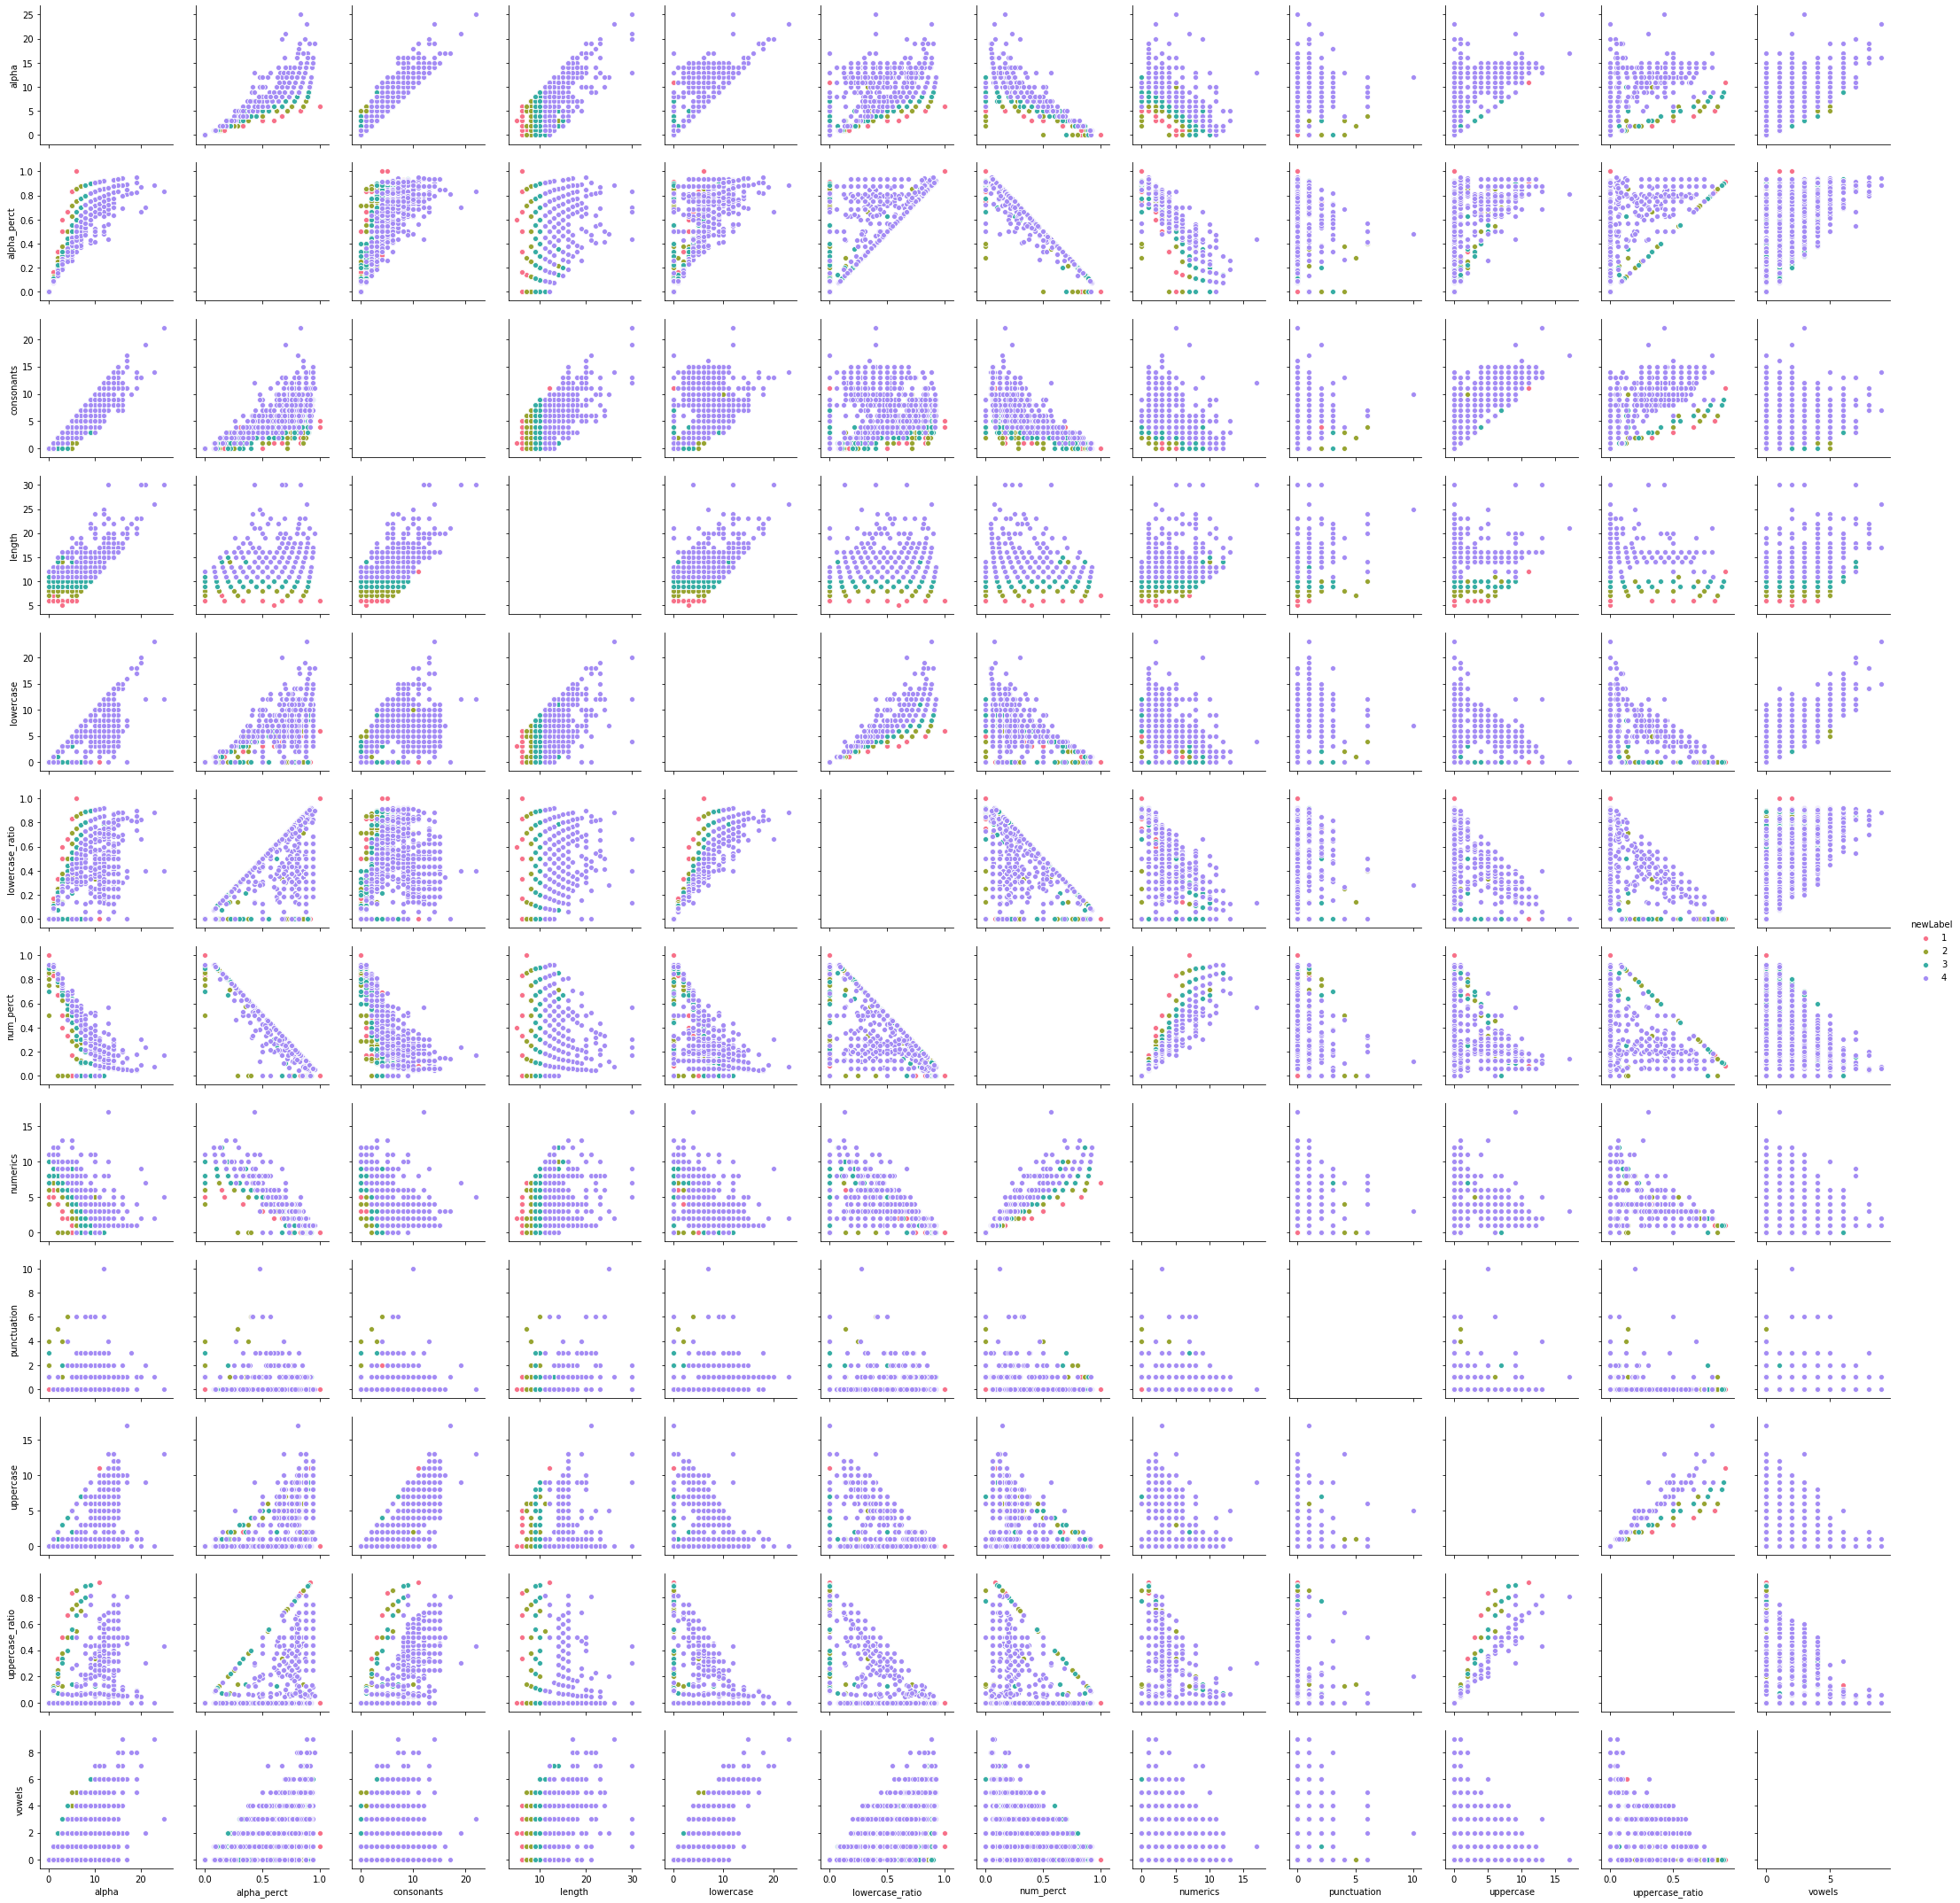

In [15]:
g = sns.pairplot(data = df1, hue = 'newLabel', vars = df1.columns.difference(['password', 'newLabel','strength']), 
                 diag_kind = {'kdae'}, palette = 'husl')


### Evaluation

In [16]:
y_test_pred = clf_svm.predict(X_test_tr)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.91      0.28      0.42       228
           2       0.73      0.73      0.73       324
           3       0.65      0.87      0.74       408
           4       0.82      0.89      0.85       238

    accuracy                           0.72      1198
   macro avg       0.78      0.69      0.69      1198
weighted avg       0.76      0.72      0.70      1198

[[ 63  71  89   5]
 [  2 235  78   9]
 [  4  14 356  34]
 [  0   0  26 212]]
